In [0]:
# Change directory to VSCode workspace root so that relative path loads work correctly. Turn this addition off with the DataScience.changeDirOnImportExport setting
# ms-python.python added
import os
try:
	os.chdir(os.path.join(os.getcwd(), '..\\..\..'))
	print(os.getcwd())
except:
	pass


 # Train and evaluate word2vec embeddings from sequences of drug orders

 ## Imports

In [1]:
import os
import pathlib
import pickle
from datetime import datetime
from multiprocessing import cpu_count

import matplotlib.pyplot as plt
import pandas as pd
import scikitplot as skplt
import seaborn as sns
import umap
from gensim.sklearn_api import W2VTransformer
from mpl_toolkits import mplot3d
from sklearn import metrics
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score
from sklearn.model_selection import GridSearchCV, cross_validate
from sklearn.pipeline import Pipeline

from mimic.components_mimic import check_ipynb


C:\Users\maxim\Anaconda3\envs\pharmai\lib\site-packages\gensim\utils.py:1197: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


 ## Global variables

 ### Save path

 Where everything will get saved. Will create a subdirectory
 called model with another subdirectory inside it with
 the date and time this block ran.

In [2]:
SAVE_STAMP = datetime.now().strftime('%Y%m%d-%H%M')
SAVE_PATH = os.path.join(os.getcwd(), 'mimic', 'model', SAVE_STAMP + 'word2vec')
pathlib.Path(SAVE_PATH).mkdir(parents=True, exist_ok=True)


 ### Word2vec hyperparameters

 #### Grid search hyperparameters
 This grid will be used when performing grid search

In [3]:
W2V_GRID = {
			'w2v__alpha': [0.01,0.013],
			'w2v__iter': [32,64],
			'w2v__size': [64,256],
			'w2v__hs': [0,1],
			'w2v__sg': [0,1],
			'w2v__min_count': [5],
			'w2v__workers':[1],
			}


 ### Clustering hyperparameters

 #### Grid search hyperparameters
 This grid will be used when performing grid search

In [4]:
CLUST_GRID = {
			'ac__n_clusters': [5,6,7,8,9,10,11,12,13,14,15],
			}


 ## Data

 Load the sequences

In [5]:
profiles_path = os.path.join(os.getcwd(), 'mimic', 'preprocessed_data_mimic', 'profiles_list.pkl')
print('Loading data from path: {}...'.format(profiles_path))
with open(profiles_path, mode='rb') as file:
	data = pickle.load(file)
data = list(data.values())
print('Data successfully loaded.')


Loading data from path: d:\Personnel\Maxime\OneDrive\Documents\Code\medorder_prediction\mimic\preprocessed_data_mimic\profiles_list.pkl...
Data successfully loaded.


 ## Transformers

 Prepare the word2vec and clustering transformers

 ### Word2vec transformer

In [6]:
w2v_pipe = Pipeline([
			('w2v', W2VTransformer()),
			])


 ### Clustering transformer

In [7]:
clust_pipe = Pipeline([
			('ac', AgglomerativeClustering()),
			])


 ## Helper functions

 These are scoring functions that will be used to score
 the word2vec embeddings and the clustering of the embeddings.

In [8]:
in_ipynb = check_ipynb().is_inipynb()

def accuracy_scorer_gensim(pipe, X=None, y=None):
	acc_dict = pipe.named_steps['w2v'].gensim_model.wv.accuracy('mimic/data/eval_analogy.txt') # YOUR ANALOGY FILE HERE, see https://radimrehurek.com/gensim/models/keyedvectors.html#gensim.models.keyedvectors.WordEmbeddingsKeyedVectors.accuracy for specifications.
	accuracy = len(acc_dict[1]['correct'])/((len(acc_dict[1]['correct'])) + (len(acc_dict[1]['incorrect'])))
	print('Accuracy is : {:.3f}'.format(accuracy))
	return accuracy

def silhouette_scorer_cosine(pipe, X=None, y=None):
	clusters = pipe.named_steps['ac'].fit_predict(X)
	score = silhouette_score(X, clusters, metric='cosine')
	print('Score is: {}'.format(score))
	return score


Execution in Jupyter Notebook detected.


 ## Word2vec grid search

 Search for the best word2vec hyperparameters, then plot the results

Performing grid search for word2vec embeddings...
Fitting 3 folds for each of 32 candidates, totalling 96 fits
[Parallel(n_jobs=-2)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=-2)]: Done  44 tasks      | elapsed: 72.3min
[Parallel(n_jobs=-2)]: Done  96 out of  96 | elapsed: 185.2min finished
Saving results of grid search for word2vec embeddings...


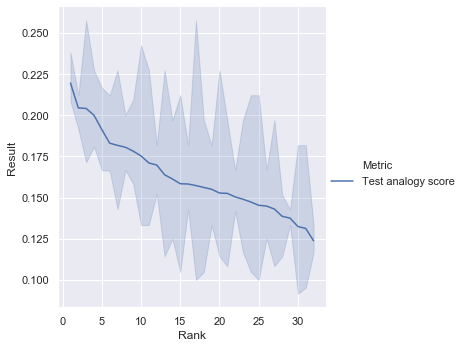

<Figure size 432x288 with 0 Axes>

In [9]:
print('Performing grid search for word2vec embeddings...')
w2v_gscv = GridSearchCV(w2v_pipe, W2V_GRID, scoring={'acc':accuracy_scorer_gensim}, cv=3, refit='acc', error_score=0, return_train_score=False, n_jobs=-2, verbose=1) # n_jobs=-2 otherwise is too cpu intensive and hangs the machine
w2v_gscv.fit(data)

# Convert results to a dataframe and save it
print('Saving results of grid search for word2vec embeddings...')
w2v_gscv_results_df = pd.DataFrame.from_dict(w2v_gscv.cv_results_)
w2v_gscv_results_df.to_csv(os.path.join(SAVE_PATH,'word2vec_gridsearch_results.csv'))
# Sort by rank
w2v_gscv_results_df.set_index('rank_test_acc', inplace=True)
# Select only useful columns
w2v_gscv_results_filtered = w2v_gscv_results_df[['split0_test_acc', 'split1_test_acc', 'split2_test_acc']].copy()
# Rename columns to clearer names
w2v_gscv_results_filtered.rename(inplace=True, index=str, columns={'split0_test_acc': 'Test analogy score', 'split1_test_acc': 'Test analogy score', 'split2_test_acc': 'Test analogy score'})
# Structure the dataframe as expected by Seaborn
w2v_gscv_results_graph_df = w2v_gscv_results_filtered.stack().reset_index()
w2v_gscv_results_graph_df.rename(inplace=True, index=str, columns={'rank_test_acc':'Rank', 'level_1':'Metric', 0:'Result'})
# Make sure the epochs are int to avoid weird ordering effects in the plot
w2v_gscv_results_graph_df['Rank'] = w2v_gscv_results_graph_df['Rank'].astype('int8')
# Plot
sns.set(style='darkgrid')
sns.relplot(x='Rank', y='Result', hue='Metric', kind='line', data=w2v_gscv_results_graph_df)
# Output the plot
if in_ipynb:
	plt.show()
else:
	plt.savefig(os.path.join(SAVE_PATH, 'word2vec_grid_search_results.png'))
# Clear
plt.gcf().clear()


 ## Clustering grid search

 Search for the best clustering hyperparameters from the
 fitted w2v grid search, then plot the results

In [10]:
print('Reducing dimensionality of word2vec embeddings for clustering...')
# Get the normalized word2vec embeddings
w2v_gscv.best_estimator_.named_steps['w2v'].gensim_model.init_sims(replace=True)
vectors = w2v_gscv.best_estimator_.named_steps['w2v'].gensim_model.wv.vectors
# Reduce dimensionality to 3D using UMAP
umapper = umap.UMAP(n_components=3)
umap_vectors = umapper.fit_transform(vectors)


Reducing dimensionality of word2vec embeddings for clustering...
C:\Users\maxim\Anaconda3\envs\pharmai\lib\site-packages\umap\umap_.py:349: NumbaWarning: 
Compilation is falling back to object mode WITH looplifting enabled because Function "fuzzy_simplicial_set" failed type inference due to: Untyped global name 'nearest_neighbors': cannot determine Numba type of <class 'function'>

File "C:\Users\maxim\Anaconda3\envs\pharmai\lib\site-packages\umap\umap_.py", line 467:
def fuzzy_simplicial_set(
    <source elided>
    if knn_indices is None or knn_dists is None:
        knn_indices, knn_dists, _ = nearest_neighbors(
        ^

  @numba.jit()
C:\Users\maxim\Anaconda3\envs\pharmai\lib\site-packages\numba\compiler.py:725: NumbaWarning: Function "fuzzy_simplicial_set" was compiled in object mode without forceobj=True.

File "C:\Users\maxim\Anaconda3\envs\pharmai\lib\site-packages\umap\umap_.py", line 350:
@numba.jit()
def fuzzy_simplicial_set(
^

  self.func_ir.loc))
C:\Users\maxim\Anaconda

Performing grid search for clustering...
Fitting 3 folds for each of 11 candidates, totalling 33 fits
[Parallel(n_jobs=-2)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=-2)]: Done  33 out of  33 | elapsed:    1.5s finished
Saving results of grid search for clustering...


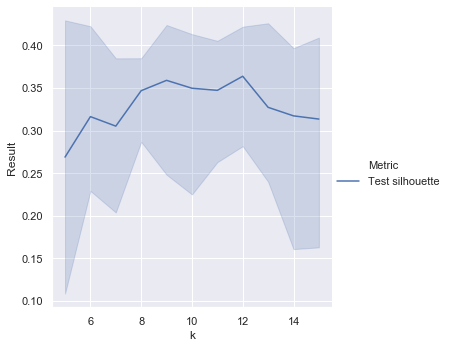

<Figure size 432x288 with 0 Axes>

In [11]:
# Do the clustering
print('Performing grid search for clustering...')
clust_gscv = GridSearchCV(clust_pipe, CLUST_GRID, scoring={'sil':silhouette_scorer_cosine}, cv=3, refit='sil', error_score=0, return_train_score=False, n_jobs=-2, verbose=1) # n_jobs=-2 otherwise is too cpu intensive and hangs the machine
clust_gscv.fit(umap_vectors)

# Convert results to a dataframe and save it
print('Saving results of grid search for clustering...')
clust_cv_results_df = pd.DataFrame.from_dict(clust_gscv.cv_results_)
clust_cv_results_df.to_csv(os.path.join(SAVE_PATH, 'clustering_grid_search_results.csv'))
# You want this to be sorted by number of clusters otherwise weird plot
clust_cv_results_df.sort_values(by='param_ac__n_clusters', inplace=True)
# Select only useful columns
clust_cv_results_filtered = clust_cv_results_df[['param_ac__n_clusters', 'split0_test_sil', 'split1_test_sil', 'split2_test_sil']].copy()
# Rename columns to clearer names
clust_cv_results_filtered.rename(inplace=True, index=str, columns={'split0_test_sil': 'Test silhouette', 'split1_test_sil': 'Test silhouette', 'split2_test_sil': 'Test silhouette', 'param_ac__n_clusters':'k'})
# Structure the dataframe as expected by Seaborn
clust_cv_results_graph_df = clust_cv_results_filtered.set_index('k').stack().reset_index()
clust_cv_results_graph_df.rename(inplace=True, index=str, columns={'level_1':'Metric', 0:'Result'})
# Plot
sns.set(style='darkgrid')
sns.relplot(x='k', y='Result', hue='Metric', kind='line', data=clust_cv_results_graph_df)
# Output the plot
if in_ipynb:
	plt.show()
else:
	plt.savefig(os.path.join(SAVE_PATH, 'cluster_grid_search_results.png'))
# Clear
plt.gcf().clear()


 ## Final embeddings
 Get final accuracy

C:\Users\maxim\Anaconda3\envs\pharmai\lib\site-packages\smart_open\smart_open_lib.py:398: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL
Accuracy is : 0.184
Reducing dimensionality of final word2vec embeddings for clustering...
Performing clustering...
Plotting silhouette graph...
Plotting clustered 3d-UMAP projected embeddings...


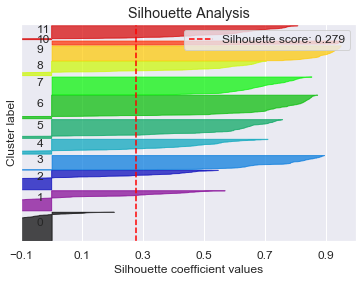

<Figure size 432x288 with 0 Axes>

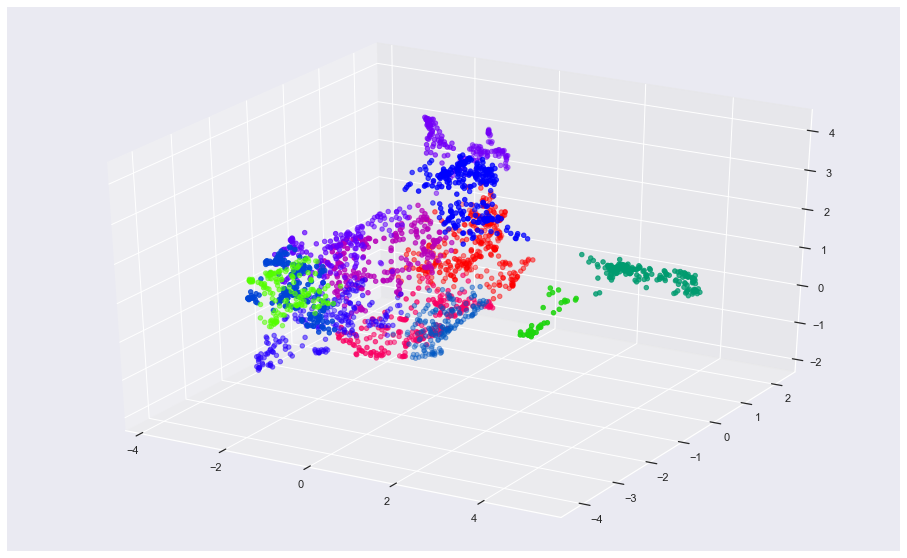

<Figure size 432x288 with 0 Axes>

In [12]:
acc = accuracy_scorer_gensim(w2v_gscv.best_estimator_)
# Get the embeddings
vectors = w2v_gscv.best_estimator_.named_steps['w2v'].gensim_model.wv.vectors
# Reduce dimensionality for clustering and plotting
print('Reducing dimensionality of final word2vec embeddings for clustering...')
umapper = umap.UMAP(n_components=3)
umap_vectors = umapper.fit_transform(vectors)
# Cluster
print('Performing clustering...')
clusters = clust_gscv.best_estimator_.fit_predict(umap_vectors)

# Plot the silhouette graph
print('Plotting silhouette graph...')
skplt.metrics.plot_silhouette(umap_vectors, clusters, metric='cosine')
# Output the plot
if in_ipynb:
	plt.show()
else:
	plt.savefig(os.path.join(SAVE_PATH, 'silhouette_plot.png'))
# Clear
plt.gcf().clear()

# Plot the 3d clustered embeddings
# Make a list of 3d coordinates and and associated cluster for each drug
print('Plotting clustered 3d-UMAP projected embeddings...')
graph_data = []
index2entity = w2v_gscv.best_estimator_.named_steps['w2v'].gensim_model.wv.index2entity
for umapcoords, cluster, entity in zip(umap_vectors, clusters, index2entity):
	graph_data.append([umapcoords[0], umapcoords[1], umapcoords[2], cluster, entity])
# Convert to dataframe
graph_data_df = pd.DataFrame(data=graph_data, columns=['x', 'y', 'z', 'cluster', 'entity'])
# Save the dataframe (to eventually manually label clusters)
graph_data_df.sort_values(by='cluster', inplace=True)
graph_data_df.to_csv(os.path.join(SAVE_PATH, 'graph_dataframe.csv'))
# Plot
ax = plt.figure(figsize=(16,10)).gca(projection='3d')
ax.scatter(
	xs=graph_data_df['x'] ,
	ys=graph_data_df['y'] ,
	zs=graph_data_df['z'] ,
	c=graph_data_df['cluster'],
	cmap='prism'
)
# Output the plot
if in_ipynb:
	plt.show()
else:
	plt.savefig(os.path.join(SAVE_PATH, 'clusted_embeddings_plot.png'))
# Clear
plt.gcf().clear()


In [14]:
print('Best hyperparameters for word2vec embeddings: {}'.format(w2v_gscv.best_params_))


Best hyperparameters for word2vec embeddings: {'w2v__alpha': 0.013, 'w2v__hs': 0, 'w2v__iter': 32, 'w2v__min_count': 5, 'w2v__sg': 1, 'w2v__size': 64, 'w2v__workers': 1}


In [15]:
W2V_GRID = {
			'w2v__alpha': [0.013, 0.02, 0.023],
			'w2v__iter': [16,32],
			'w2v__size': [64,128],
			'w2v__hs': [0,1],
			'w2v__sg': [0,1],
			'w2v__min_count': [5],
			'w2v__workers':[1],
			}


Performing grid search for word2vec embeddings...
Fitting 3 folds for each of 48 candidates, totalling 144 fits
[Parallel(n_jobs=-2)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=-2)]: Done  44 tasks      | elapsed: 30.7min
[Parallel(n_jobs=-2)]: Done 144 out of 144 | elapsed: 113.7min finished
Saving results of grid search for word2vec embeddings...


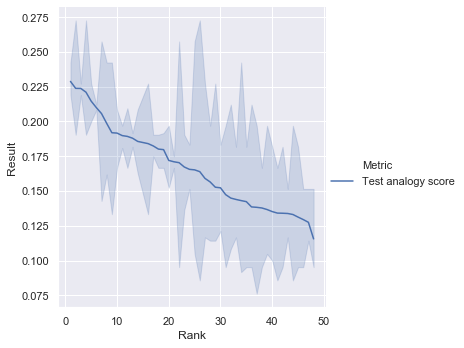

<Figure size 432x288 with 0 Axes>

In [16]:
print('Performing grid search for word2vec embeddings...')
w2v_gscv = GridSearchCV(w2v_pipe, W2V_GRID, scoring={'acc':accuracy_scorer_gensim}, cv=3, refit='acc', error_score=0, return_train_score=False, n_jobs=-2, verbose=1) # n_jobs=-2 otherwise is too cpu intensive and hangs the machine
w2v_gscv.fit(data)

# Convert results to a dataframe and save it
print('Saving results of grid search for word2vec embeddings...')
w2v_gscv_results_df = pd.DataFrame.from_dict(w2v_gscv.cv_results_)
w2v_gscv_results_df.to_csv(os.path.join(SAVE_PATH,'word2vec_gridsearch_results.csv'))
# Sort by rank
w2v_gscv_results_df.set_index('rank_test_acc', inplace=True)
# Select only useful columns
w2v_gscv_results_filtered = w2v_gscv_results_df[['split0_test_acc', 'split1_test_acc', 'split2_test_acc']].copy()
# Rename columns to clearer names
w2v_gscv_results_filtered.rename(inplace=True, index=str, columns={'split0_test_acc': 'Test analogy score', 'split1_test_acc': 'Test analogy score', 'split2_test_acc': 'Test analogy score'})
# Structure the dataframe as expected by Seaborn
w2v_gscv_results_graph_df = w2v_gscv_results_filtered.stack().reset_index()
w2v_gscv_results_graph_df.rename(inplace=True, index=str, columns={'rank_test_acc':'Rank', 'level_1':'Metric', 0:'Result'})
# Make sure the epochs are int to avoid weird ordering effects in the plot
w2v_gscv_results_graph_df['Rank'] = w2v_gscv_results_graph_df['Rank'].astype('int8')
# Plot
sns.set(style='darkgrid')
sns.relplot(x='Rank', y='Result', hue='Metric', kind='line', data=w2v_gscv_results_graph_df)
# Output the plot
if in_ipynb:
	plt.show()
else:
	plt.savefig(os.path.join(SAVE_PATH, 'word2vec_grid_search_results.png'))
# Clear
plt.gcf().clear()


 ## Clustering grid search

 Search for the best clustering hyperparameters from the
 fitted w2v grid search, then plot the results

In [17]:
print('Reducing dimensionality of word2vec embeddings for clustering...')
# Get the normalized word2vec embeddings
w2v_gscv.best_estimator_.named_steps['w2v'].gensim_model.init_sims(replace=True)
vectors = w2v_gscv.best_estimator_.named_steps['w2v'].gensim_model.wv.vectors
# Reduce dimensionality to 3D using UMAP
umapper = umap.UMAP(n_components=3)
umap_vectors = umapper.fit_transform(vectors)


Reducing dimensionality of word2vec embeddings for clustering...


Performing grid search for clustering...
Fitting 3 folds for each of 11 candidates, totalling 33 fits
[Parallel(n_jobs=-2)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=-2)]: Done  28 out of  33 | elapsed:    1.7s remaining:    0.2s
[Parallel(n_jobs=-2)]: Done  33 out of  33 | elapsed:    1.9s finished
Saving results of grid search for clustering...


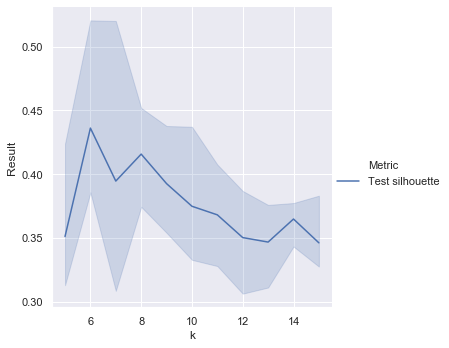

<Figure size 432x288 with 0 Axes>

In [18]:
# Do the clustering
print('Performing grid search for clustering...')
clust_gscv = GridSearchCV(clust_pipe, CLUST_GRID, scoring={'sil':silhouette_scorer_cosine}, cv=3, refit='sil', error_score=0, return_train_score=False, n_jobs=-2, verbose=1) # n_jobs=-2 otherwise is too cpu intensive and hangs the machine
clust_gscv.fit(umap_vectors)

# Convert results to a dataframe and save it
print('Saving results of grid search for clustering...')
clust_cv_results_df = pd.DataFrame.from_dict(clust_gscv.cv_results_)
clust_cv_results_df.to_csv(os.path.join(SAVE_PATH, 'clustering_grid_search_results.csv'))
# You want this to be sorted by number of clusters otherwise weird plot
clust_cv_results_df.sort_values(by='param_ac__n_clusters', inplace=True)
# Select only useful columns
clust_cv_results_filtered = clust_cv_results_df[['param_ac__n_clusters', 'split0_test_sil', 'split1_test_sil', 'split2_test_sil']].copy()
# Rename columns to clearer names
clust_cv_results_filtered.rename(inplace=True, index=str, columns={'split0_test_sil': 'Test silhouette', 'split1_test_sil': 'Test silhouette', 'split2_test_sil': 'Test silhouette', 'param_ac__n_clusters':'k'})
# Structure the dataframe as expected by Seaborn
clust_cv_results_graph_df = clust_cv_results_filtered.set_index('k').stack().reset_index()
clust_cv_results_graph_df.rename(inplace=True, index=str, columns={'level_1':'Metric', 0:'Result'})
# Plot
sns.set(style='darkgrid')
sns.relplot(x='k', y='Result', hue='Metric', kind='line', data=clust_cv_results_graph_df)
# Output the plot
if in_ipynb:
	plt.show()
else:
	plt.savefig(os.path.join(SAVE_PATH, 'cluster_grid_search_results.png'))
# Clear
plt.gcf().clear()


 ## Final embeddings
 Get final accuracy

C:\Users\maxim\Anaconda3\envs\pharmai\lib\site-packages\smart_open\smart_open_lib.py:398: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL
Accuracy is : 0.169
Reducing dimensionality of final word2vec embeddings for clustering...
Performing clustering...
Plotting silhouette graph...
Plotting clustered 3d-UMAP projected embeddings...


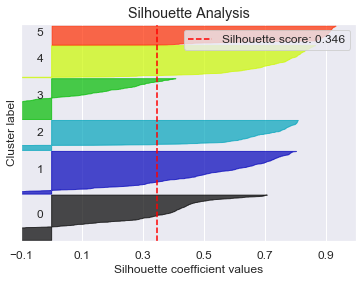

<Figure size 432x288 with 0 Axes>

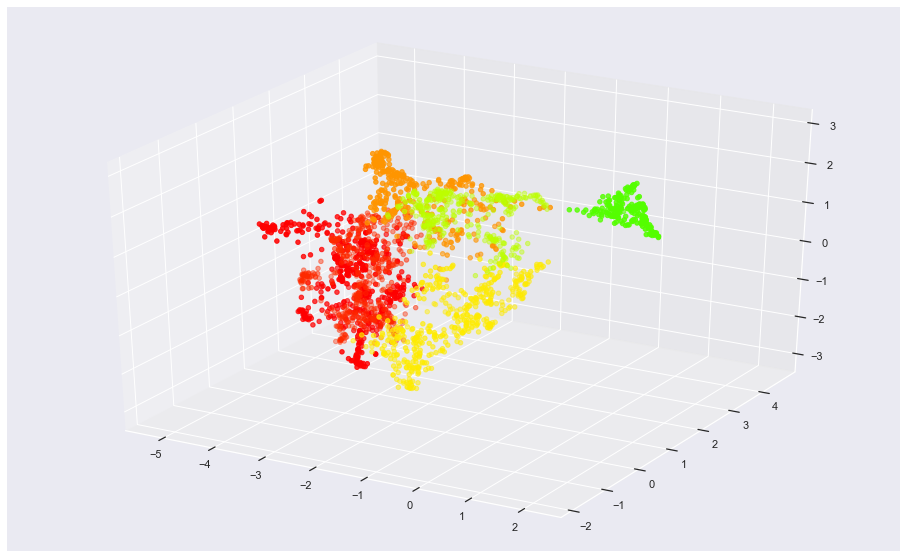

<Figure size 432x288 with 0 Axes>

In [19]:
acc = accuracy_scorer_gensim(w2v_gscv.best_estimator_)
# Get the embeddings
vectors = w2v_gscv.best_estimator_.named_steps['w2v'].gensim_model.wv.vectors
# Reduce dimensionality for clustering and plotting
print('Reducing dimensionality of final word2vec embeddings for clustering...')
umapper = umap.UMAP(n_components=3)
umap_vectors = umapper.fit_transform(vectors)
# Cluster
print('Performing clustering...')
clusters = clust_gscv.best_estimator_.fit_predict(umap_vectors)

# Plot the silhouette graph
print('Plotting silhouette graph...')
skplt.metrics.plot_silhouette(umap_vectors, clusters, metric='cosine')
# Output the plot
if in_ipynb:
	plt.show()
else:
	plt.savefig(os.path.join(SAVE_PATH, 'silhouette_plot.png'))
# Clear
plt.gcf().clear()

# Plot the 3d clustered embeddings
# Make a list of 3d coordinates and and associated cluster for each drug
print('Plotting clustered 3d-UMAP projected embeddings...')
graph_data = []
index2entity = w2v_gscv.best_estimator_.named_steps['w2v'].gensim_model.wv.index2entity
for umapcoords, cluster, entity in zip(umap_vectors, clusters, index2entity):
	graph_data.append([umapcoords[0], umapcoords[1], umapcoords[2], cluster, entity])
# Convert to dataframe
graph_data_df = pd.DataFrame(data=graph_data, columns=['x', 'y', 'z', 'cluster', 'entity'])
# Save the dataframe (to eventually manually label clusters)
graph_data_df.sort_values(by='cluster', inplace=True)
graph_data_df.to_csv(os.path.join(SAVE_PATH, 'graph_dataframe.csv'))
# Plot
ax = plt.figure(figsize=(16,10)).gca(projection='3d')
ax.scatter(
	xs=graph_data_df['x'] ,
	ys=graph_data_df['y'] ,
	zs=graph_data_df['z'] ,
	c=graph_data_df['cluster'],
	cmap='prism'
)
# Output the plot
if in_ipynb:
	plt.show()
else:
	plt.savefig(os.path.join(SAVE_PATH, 'clusted_embeddings_plot.png'))
# Clear
plt.gcf().clear()


In [20]:
print('Best hyperparameters for word2vec embeddings: {}'.format(w2v_gscv.best_params_))


Best hyperparameters for word2vec embeddings: {'w2v__alpha': 0.02, 'w2v__hs': 0, 'w2v__iter': 32, 'w2v__min_count': 5, 'w2v__sg': 1, 'w2v__size': 64, 'w2v__workers': 1}


In [21]:
W2V_GRID = {
			'w2v__alpha': [0.018, 0.02],
			'w2v__iter': [32,64],
			'w2v__size': [64,128],
			'w2v__hs': [0],
			'w2v__sg': [1],
			'w2v__min_count': [5],
			'w2v__workers':[1],
			}


 ## Word2vec grid search

 Search for the best word2vec hyperparameters, then plot the results

Performing grid search for word2vec embeddings...
Fitting 3 folds for each of 8 candidates, totalling 24 fits
[Parallel(n_jobs=-2)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=-2)]: Done  24 out of  24 | elapsed: 40.1min finished
Saving results of grid search for word2vec embeddings...


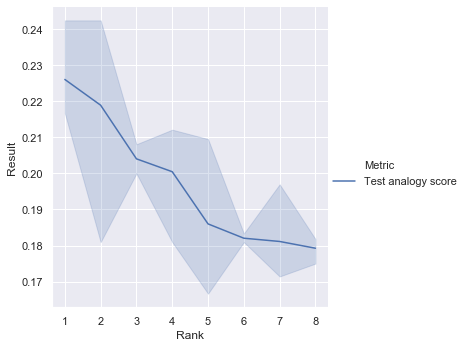

<Figure size 432x288 with 0 Axes>

In [22]:
print('Performing grid search for word2vec embeddings...')
w2v_gscv = GridSearchCV(w2v_pipe, W2V_GRID, scoring={'acc':accuracy_scorer_gensim}, cv=3, refit='acc', error_score=0, return_train_score=False, n_jobs=-2, verbose=1) # n_jobs=-2 otherwise is too cpu intensive and hangs the machine
w2v_gscv.fit(data)

# Convert results to a dataframe and save it
print('Saving results of grid search for word2vec embeddings...')
w2v_gscv_results_df = pd.DataFrame.from_dict(w2v_gscv.cv_results_)
w2v_gscv_results_df.to_csv(os.path.join(SAVE_PATH,'word2vec_gridsearch_results.csv'))
# Sort by rank
w2v_gscv_results_df.set_index('rank_test_acc', inplace=True)
# Select only useful columns
w2v_gscv_results_filtered = w2v_gscv_results_df[['split0_test_acc', 'split1_test_acc', 'split2_test_acc']].copy()
# Rename columns to clearer names
w2v_gscv_results_filtered.rename(inplace=True, index=str, columns={'split0_test_acc': 'Test analogy score', 'split1_test_acc': 'Test analogy score', 'split2_test_acc': 'Test analogy score'})
# Structure the dataframe as expected by Seaborn
w2v_gscv_results_graph_df = w2v_gscv_results_filtered.stack().reset_index()
w2v_gscv_results_graph_df.rename(inplace=True, index=str, columns={'rank_test_acc':'Rank', 'level_1':'Metric', 0:'Result'})
# Make sure the epochs are int to avoid weird ordering effects in the plot
w2v_gscv_results_graph_df['Rank'] = w2v_gscv_results_graph_df['Rank'].astype('int8')
# Plot
sns.set(style='darkgrid')
sns.relplot(x='Rank', y='Result', hue='Metric', kind='line', data=w2v_gscv_results_graph_df)
# Output the plot
if in_ipynb:
	plt.show()
else:
	plt.savefig(os.path.join(SAVE_PATH, 'word2vec_grid_search_results.png'))
# Clear
plt.gcf().clear()


 ## Clustering grid search

 Search for the best clustering hyperparameters from the
 fitted w2v grid search, then plot the results

In [23]:
print('Reducing dimensionality of word2vec embeddings for clustering...')
# Get the normalized word2vec embeddings
w2v_gscv.best_estimator_.named_steps['w2v'].gensim_model.init_sims(replace=True)
vectors = w2v_gscv.best_estimator_.named_steps['w2v'].gensim_model.wv.vectors
# Reduce dimensionality to 3D using UMAP
umapper = umap.UMAP(n_components=3)
umap_vectors = umapper.fit_transform(vectors)


Reducing dimensionality of word2vec embeddings for clustering...


Performing grid search for clustering...
Fitting 3 folds for each of 11 candidates, totalling 33 fits
[Parallel(n_jobs=-2)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=-2)]: Done  33 out of  33 | elapsed:    2.8s finished
Saving results of grid search for clustering...


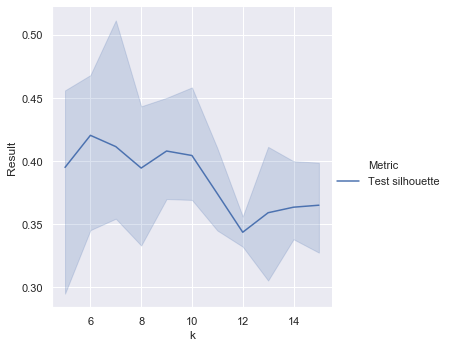

<Figure size 432x288 with 0 Axes>

In [24]:
# Do the clustering
print('Performing grid search for clustering...')
clust_gscv = GridSearchCV(clust_pipe, CLUST_GRID, scoring={'sil':silhouette_scorer_cosine}, cv=3, refit='sil', error_score=0, return_train_score=False, n_jobs=-2, verbose=1) # n_jobs=-2 otherwise is too cpu intensive and hangs the machine
clust_gscv.fit(umap_vectors)

# Convert results to a dataframe and save it
print('Saving results of grid search for clustering...')
clust_cv_results_df = pd.DataFrame.from_dict(clust_gscv.cv_results_)
clust_cv_results_df.to_csv(os.path.join(SAVE_PATH, 'clustering_grid_search_results.csv'))
# You want this to be sorted by number of clusters otherwise weird plot
clust_cv_results_df.sort_values(by='param_ac__n_clusters', inplace=True)
# Select only useful columns
clust_cv_results_filtered = clust_cv_results_df[['param_ac__n_clusters', 'split0_test_sil', 'split1_test_sil', 'split2_test_sil']].copy()
# Rename columns to clearer names
clust_cv_results_filtered.rename(inplace=True, index=str, columns={'split0_test_sil': 'Test silhouette', 'split1_test_sil': 'Test silhouette', 'split2_test_sil': 'Test silhouette', 'param_ac__n_clusters':'k'})
# Structure the dataframe as expected by Seaborn
clust_cv_results_graph_df = clust_cv_results_filtered.set_index('k').stack().reset_index()
clust_cv_results_graph_df.rename(inplace=True, index=str, columns={'level_1':'Metric', 0:'Result'})
# Plot
sns.set(style='darkgrid')
sns.relplot(x='k', y='Result', hue='Metric', kind='line', data=clust_cv_results_graph_df)
# Output the plot
if in_ipynb:
	plt.show()
else:
	plt.savefig(os.path.join(SAVE_PATH, 'cluster_grid_search_results.png'))
# Clear
plt.gcf().clear()


 ## Final embeddings
 Get final accuracy

C:\Users\maxim\Anaconda3\envs\pharmai\lib\site-packages\smart_open\smart_open_lib.py:398: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL
Accuracy is : 0.169
Reducing dimensionality of final word2vec embeddings for clustering...
Performing clustering...
Plotting silhouette graph...
Plotting clustered 3d-UMAP projected embeddings...


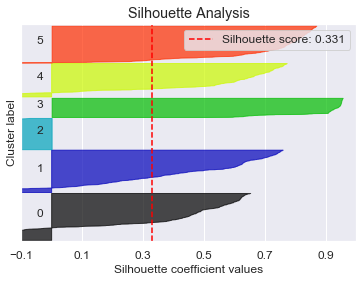

<Figure size 432x288 with 0 Axes>

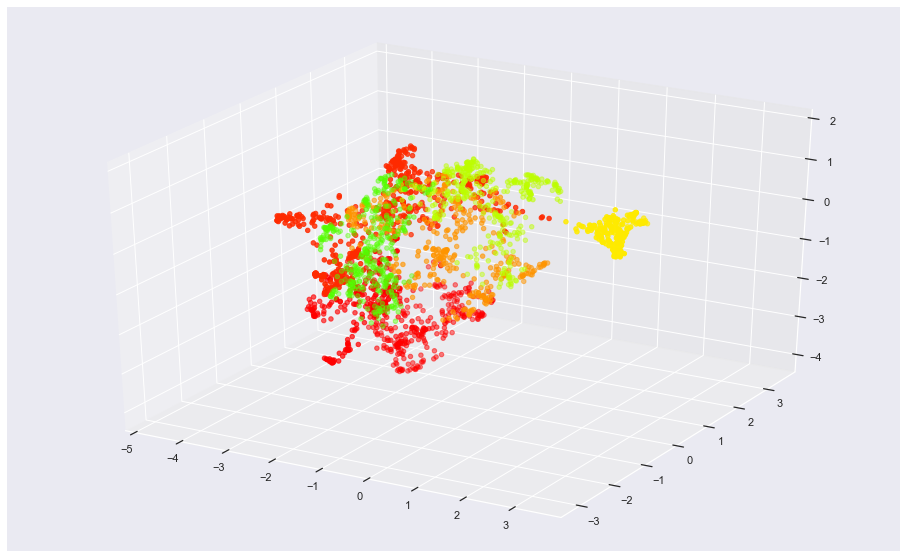

<Figure size 432x288 with 0 Axes>

In [25]:
acc = accuracy_scorer_gensim(w2v_gscv.best_estimator_)
# Get the embeddings
vectors = w2v_gscv.best_estimator_.named_steps['w2v'].gensim_model.wv.vectors
# Reduce dimensionality for clustering and plotting
print('Reducing dimensionality of final word2vec embeddings for clustering...')
umapper = umap.UMAP(n_components=3)
umap_vectors = umapper.fit_transform(vectors)
# Cluster
print('Performing clustering...')
clusters = clust_gscv.best_estimator_.fit_predict(umap_vectors)

# Plot the silhouette graph
print('Plotting silhouette graph...')
skplt.metrics.plot_silhouette(umap_vectors, clusters, metric='cosine')
# Output the plot
if in_ipynb:
	plt.show()
else:
	plt.savefig(os.path.join(SAVE_PATH, 'silhouette_plot.png'))
# Clear
plt.gcf().clear()

# Plot the 3d clustered embeddings
# Make a list of 3d coordinates and and associated cluster for each drug
print('Plotting clustered 3d-UMAP projected embeddings...')
graph_data = []
index2entity = w2v_gscv.best_estimator_.named_steps['w2v'].gensim_model.wv.index2entity
for umapcoords, cluster, entity in zip(umap_vectors, clusters, index2entity):
	graph_data.append([umapcoords[0], umapcoords[1], umapcoords[2], cluster, entity])
# Convert to dataframe
graph_data_df = pd.DataFrame(data=graph_data, columns=['x', 'y', 'z', 'cluster', 'entity'])
# Save the dataframe (to eventually manually label clusters)
graph_data_df.sort_values(by='cluster', inplace=True)
graph_data_df.to_csv(os.path.join(SAVE_PATH, 'graph_dataframe.csv'))
# Plot
ax = plt.figure(figsize=(16,10)).gca(projection='3d')
ax.scatter(
	xs=graph_data_df['x'] ,
	ys=graph_data_df['y'] ,
	zs=graph_data_df['z'] ,
	c=graph_data_df['cluster'],
	cmap='prism'
)
# Output the plot
if in_ipynb:
	plt.show()
else:
	plt.savefig(os.path.join(SAVE_PATH, 'clusted_embeddings_plot.png'))
# Clear
plt.gcf().clear()


In [26]:
print('Best hyperparameters for word2vec embeddings: {}'.format(w2v_gscv.best_params_))


Best hyperparameters for word2vec embeddings: {'w2v__alpha': 0.02, 'w2v__hs': 0, 'w2v__iter': 32, 'w2v__min_count': 5, 'w2v__sg': 1, 'w2v__size': 64, 'w2v__workers': 1}


In [27]:
W2V_GRID = {
			'w2v__alpha': [0.02, 0.023],
			'w2v__iter': [32,64],
			'w2v__size': [64],
			'w2v__hs': [0],
			'w2v__sg': [1],
			'w2v__min_count': [5],
			'w2v__workers':[1],
			}


 ## Word2vec grid search

 Search for the best word2vec hyperparameters, then plot the results

Performing grid search for word2vec embeddings...
Fitting 3 folds for each of 4 candidates, totalling 12 fits
[Parallel(n_jobs=-2)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=-2)]: Done  12 out of  12 | elapsed: 18.0min finished
Saving results of grid search for word2vec embeddings...


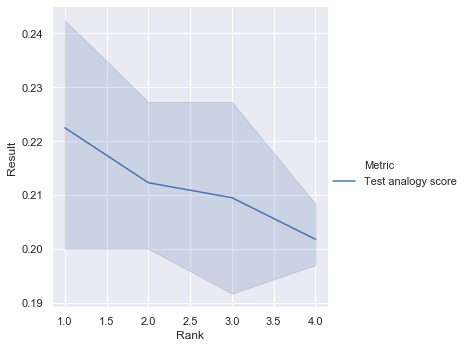

<Figure size 432x288 with 0 Axes>

In [28]:
print('Performing grid search for word2vec embeddings...')
w2v_gscv = GridSearchCV(w2v_pipe, W2V_GRID, scoring={'acc':accuracy_scorer_gensim}, cv=3, refit='acc', error_score=0, return_train_score=False, n_jobs=-2, verbose=1) # n_jobs=-2 otherwise is too cpu intensive and hangs the machine
w2v_gscv.fit(data)

# Convert results to a dataframe and save it
print('Saving results of grid search for word2vec embeddings...')
w2v_gscv_results_df = pd.DataFrame.from_dict(w2v_gscv.cv_results_)
w2v_gscv_results_df.to_csv(os.path.join(SAVE_PATH,'word2vec_gridsearch_results.csv'))
# Sort by rank
w2v_gscv_results_df.set_index('rank_test_acc', inplace=True)
# Select only useful columns
w2v_gscv_results_filtered = w2v_gscv_results_df[['split0_test_acc', 'split1_test_acc', 'split2_test_acc']].copy()
# Rename columns to clearer names
w2v_gscv_results_filtered.rename(inplace=True, index=str, columns={'split0_test_acc': 'Test analogy score', 'split1_test_acc': 'Test analogy score', 'split2_test_acc': 'Test analogy score'})
# Structure the dataframe as expected by Seaborn
w2v_gscv_results_graph_df = w2v_gscv_results_filtered.stack().reset_index()
w2v_gscv_results_graph_df.rename(inplace=True, index=str, columns={'rank_test_acc':'Rank', 'level_1':'Metric', 0:'Result'})
# Make sure the epochs are int to avoid weird ordering effects in the plot
w2v_gscv_results_graph_df['Rank'] = w2v_gscv_results_graph_df['Rank'].astype('int8')
# Plot
sns.set(style='darkgrid')
sns.relplot(x='Rank', y='Result', hue='Metric', kind='line', data=w2v_gscv_results_graph_df)
# Output the plot
if in_ipynb:
	plt.show()
else:
	plt.savefig(os.path.join(SAVE_PATH, 'word2vec_grid_search_results.png'))
# Clear
plt.gcf().clear()


 ## Clustering grid search

 Search for the best clustering hyperparameters from the
 fitted w2v grid search, then plot the results

In [29]:
print('Reducing dimensionality of word2vec embeddings for clustering...')
# Get the normalized word2vec embeddings
w2v_gscv.best_estimator_.named_steps['w2v'].gensim_model.init_sims(replace=True)
vectors = w2v_gscv.best_estimator_.named_steps['w2v'].gensim_model.wv.vectors
# Reduce dimensionality to 3D using UMAP
umapper = umap.UMAP(n_components=3)
umap_vectors = umapper.fit_transform(vectors)


Reducing dimensionality of word2vec embeddings for clustering...


Performing grid search for clustering...
Fitting 3 folds for each of 11 candidates, totalling 33 fits
[Parallel(n_jobs=-2)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=-2)]: Done  33 out of  33 | elapsed:    2.1s finished
Saving results of grid search for clustering...


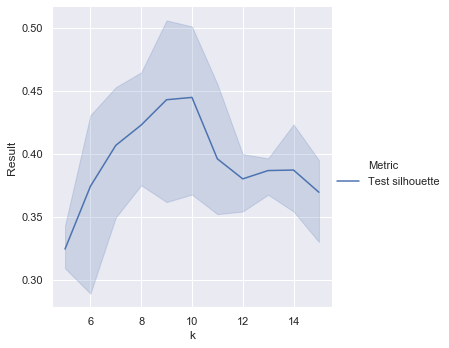

<Figure size 432x288 with 0 Axes>

In [30]:
# Do the clustering
print('Performing grid search for clustering...')
clust_gscv = GridSearchCV(clust_pipe, CLUST_GRID, scoring={'sil':silhouette_scorer_cosine}, cv=3, refit='sil', error_score=0, return_train_score=False, n_jobs=-2, verbose=1) # n_jobs=-2 otherwise is too cpu intensive and hangs the machine
clust_gscv.fit(umap_vectors)

# Convert results to a dataframe and save it
print('Saving results of grid search for clustering...')
clust_cv_results_df = pd.DataFrame.from_dict(clust_gscv.cv_results_)
clust_cv_results_df.to_csv(os.path.join(SAVE_PATH, 'clustering_grid_search_results.csv'))
# You want this to be sorted by number of clusters otherwise weird plot
clust_cv_results_df.sort_values(by='param_ac__n_clusters', inplace=True)
# Select only useful columns
clust_cv_results_filtered = clust_cv_results_df[['param_ac__n_clusters', 'split0_test_sil', 'split1_test_sil', 'split2_test_sil']].copy()
# Rename columns to clearer names
clust_cv_results_filtered.rename(inplace=True, index=str, columns={'split0_test_sil': 'Test silhouette', 'split1_test_sil': 'Test silhouette', 'split2_test_sil': 'Test silhouette', 'param_ac__n_clusters':'k'})
# Structure the dataframe as expected by Seaborn
clust_cv_results_graph_df = clust_cv_results_filtered.set_index('k').stack().reset_index()
clust_cv_results_graph_df.rename(inplace=True, index=str, columns={'level_1':'Metric', 0:'Result'})
# Plot
sns.set(style='darkgrid')
sns.relplot(x='k', y='Result', hue='Metric', kind='line', data=clust_cv_results_graph_df)
# Output the plot
if in_ipynb:
	plt.show()
else:
	plt.savefig(os.path.join(SAVE_PATH, 'cluster_grid_search_results.png'))
# Clear
plt.gcf().clear()


 ## Final embeddings
 Get final accuracy

C:\Users\maxim\Anaconda3\envs\pharmai\lib\site-packages\smart_open\smart_open_lib.py:398: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL
Accuracy is : 0.169
Reducing dimensionality of final word2vec embeddings for clustering...
Performing clustering...
Plotting silhouette graph...
Plotting clustered 3d-UMAP projected embeddings...


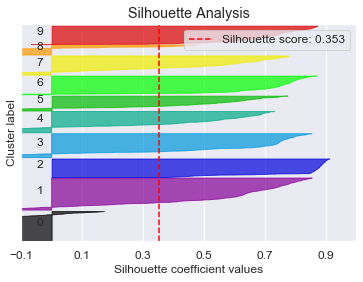

<Figure size 432x288 with 0 Axes>

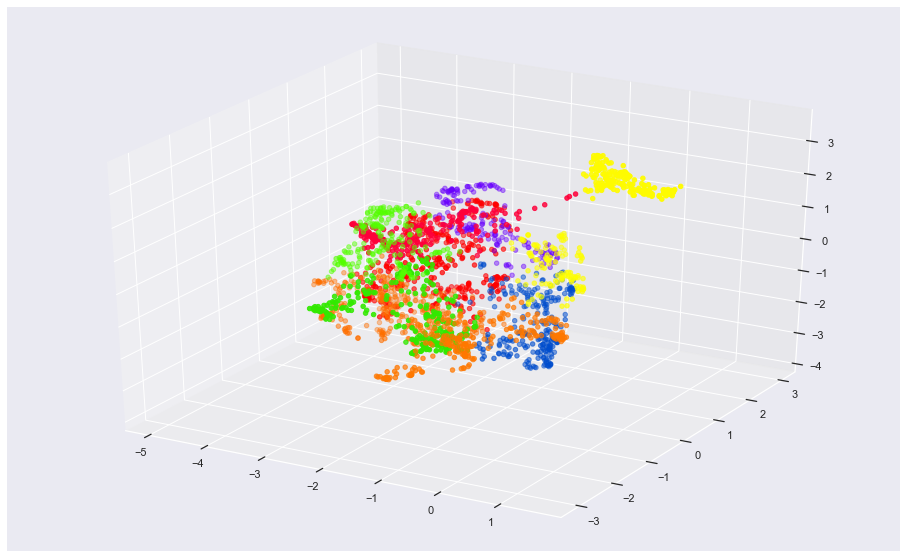

<Figure size 432x288 with 0 Axes>

In [31]:
acc = accuracy_scorer_gensim(w2v_gscv.best_estimator_)
# Get the embeddings
vectors = w2v_gscv.best_estimator_.named_steps['w2v'].gensim_model.wv.vectors
# Reduce dimensionality for clustering and plotting
print('Reducing dimensionality of final word2vec embeddings for clustering...')
umapper = umap.UMAP(n_components=3)
umap_vectors = umapper.fit_transform(vectors)
# Cluster
print('Performing clustering...')
clusters = clust_gscv.best_estimator_.fit_predict(umap_vectors)

# Plot the silhouette graph
print('Plotting silhouette graph...')
skplt.metrics.plot_silhouette(umap_vectors, clusters, metric='cosine')
# Output the plot
if in_ipynb:
	plt.show()
else:
	plt.savefig(os.path.join(SAVE_PATH, 'silhouette_plot.png'))
# Clear
plt.gcf().clear()

# Plot the 3d clustered embeddings
# Make a list of 3d coordinates and and associated cluster for each drug
print('Plotting clustered 3d-UMAP projected embeddings...')
graph_data = []
index2entity = w2v_gscv.best_estimator_.named_steps['w2v'].gensim_model.wv.index2entity
for umapcoords, cluster, entity in zip(umap_vectors, clusters, index2entity):
	graph_data.append([umapcoords[0], umapcoords[1], umapcoords[2], cluster, entity])
# Convert to dataframe
graph_data_df = pd.DataFrame(data=graph_data, columns=['x', 'y', 'z', 'cluster', 'entity'])
# Save the dataframe (to eventually manually label clusters)
graph_data_df.sort_values(by='cluster', inplace=True)
graph_data_df.to_csv(os.path.join(SAVE_PATH, 'graph_dataframe.csv'))
# Plot
ax = plt.figure(figsize=(16,10)).gca(projection='3d')
ax.scatter(
	xs=graph_data_df['x'] ,
	ys=graph_data_df['y'] ,
	zs=graph_data_df['z'] ,
	c=graph_data_df['cluster'],
	cmap='prism'
)
# Output the plot
if in_ipynb:
	plt.show()
else:
	plt.savefig(os.path.join(SAVE_PATH, 'clusted_embeddings_plot.png'))
# Clear
plt.gcf().clear()


In [32]:
print('Best hyperparameters for word2vec embeddings: {}'.format(w2v_gscv.best_params_))


Best hyperparameters for word2vec embeddings: {'w2v__alpha': 0.023, 'w2v__hs': 0, 'w2v__iter': 32, 'w2v__min_count': 5, 'w2v__sg': 1, 'w2v__size': 64, 'w2v__workers': 1}


In [33]:
W2V_GRID = {
			'w2v__alpha': [0.023, 0.03, 0.033, 0.04],
			'w2v__iter': [32],
			'w2v__size': [64],
			'w2v__hs': [0],
			'w2v__sg': [1],
			'w2v__min_count': [5],
			'w2v__workers':[1],
			}


 ## Word2vec grid search

 Search for the best word2vec hyperparameters, then plot the results

Performing grid search for word2vec embeddings...
Fitting 3 folds for each of 4 candidates, totalling 12 fits
[Parallel(n_jobs=-2)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=-2)]: Done  12 out of  12 | elapsed: 11.9min finished
Saving results of grid search for word2vec embeddings...


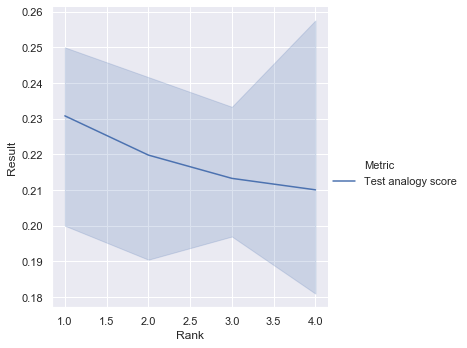

<Figure size 432x288 with 0 Axes>

In [34]:
print('Performing grid search for word2vec embeddings...')
w2v_gscv = GridSearchCV(w2v_pipe, W2V_GRID, scoring={'acc':accuracy_scorer_gensim}, cv=3, refit='acc', error_score=0, return_train_score=False, n_jobs=-2, verbose=1) # n_jobs=-2 otherwise is too cpu intensive and hangs the machine
w2v_gscv.fit(data)

# Convert results to a dataframe and save it
print('Saving results of grid search for word2vec embeddings...')
w2v_gscv_results_df = pd.DataFrame.from_dict(w2v_gscv.cv_results_)
w2v_gscv_results_df.to_csv(os.path.join(SAVE_PATH,'word2vec_gridsearch_results.csv'))
# Sort by rank
w2v_gscv_results_df.set_index('rank_test_acc', inplace=True)
# Select only useful columns
w2v_gscv_results_filtered = w2v_gscv_results_df[['split0_test_acc', 'split1_test_acc', 'split2_test_acc']].copy()
# Rename columns to clearer names
w2v_gscv_results_filtered.rename(inplace=True, index=str, columns={'split0_test_acc': 'Test analogy score', 'split1_test_acc': 'Test analogy score', 'split2_test_acc': 'Test analogy score'})
# Structure the dataframe as expected by Seaborn
w2v_gscv_results_graph_df = w2v_gscv_results_filtered.stack().reset_index()
w2v_gscv_results_graph_df.rename(inplace=True, index=str, columns={'rank_test_acc':'Rank', 'level_1':'Metric', 0:'Result'})
# Make sure the epochs are int to avoid weird ordering effects in the plot
w2v_gscv_results_graph_df['Rank'] = w2v_gscv_results_graph_df['Rank'].astype('int8')
# Plot
sns.set(style='darkgrid')
sns.relplot(x='Rank', y='Result', hue='Metric', kind='line', data=w2v_gscv_results_graph_df)
# Output the plot
if in_ipynb:
	plt.show()
else:
	plt.savefig(os.path.join(SAVE_PATH, 'word2vec_grid_search_results.png'))
# Clear
plt.gcf().clear()


 ## Clustering grid search

 Search for the best clustering hyperparameters from the
 fitted w2v grid search, then plot the results

In [35]:
print('Reducing dimensionality of word2vec embeddings for clustering...')
# Get the normalized word2vec embeddings
w2v_gscv.best_estimator_.named_steps['w2v'].gensim_model.init_sims(replace=True)
vectors = w2v_gscv.best_estimator_.named_steps['w2v'].gensim_model.wv.vectors
# Reduce dimensionality to 3D using UMAP
umapper = umap.UMAP(n_components=3)
umap_vectors = umapper.fit_transform(vectors)


Reducing dimensionality of word2vec embeddings for clustering...


Performing grid search for clustering...
Fitting 3 folds for each of 11 candidates, totalling 33 fits
[Parallel(n_jobs=-2)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=-2)]: Done  33 out of  33 | elapsed:    2.2s finished
Saving results of grid search for clustering...


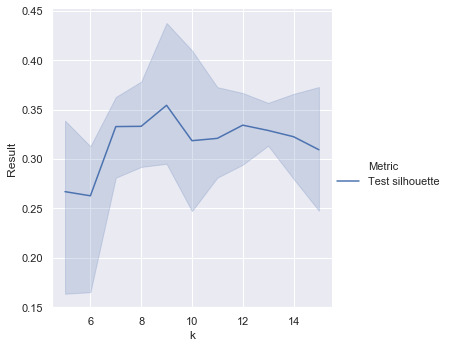

<Figure size 432x288 with 0 Axes>

In [36]:
# Do the clustering
print('Performing grid search for clustering...')
clust_gscv = GridSearchCV(clust_pipe, CLUST_GRID, scoring={'sil':silhouette_scorer_cosine}, cv=3, refit='sil', error_score=0, return_train_score=False, n_jobs=-2, verbose=1) # n_jobs=-2 otherwise is too cpu intensive and hangs the machine
clust_gscv.fit(umap_vectors)

# Convert results to a dataframe and save it
print('Saving results of grid search for clustering...')
clust_cv_results_df = pd.DataFrame.from_dict(clust_gscv.cv_results_)
clust_cv_results_df.to_csv(os.path.join(SAVE_PATH, 'clustering_grid_search_results.csv'))
# You want this to be sorted by number of clusters otherwise weird plot
clust_cv_results_df.sort_values(by='param_ac__n_clusters', inplace=True)
# Select only useful columns
clust_cv_results_filtered = clust_cv_results_df[['param_ac__n_clusters', 'split0_test_sil', 'split1_test_sil', 'split2_test_sil']].copy()
# Rename columns to clearer names
clust_cv_results_filtered.rename(inplace=True, index=str, columns={'split0_test_sil': 'Test silhouette', 'split1_test_sil': 'Test silhouette', 'split2_test_sil': 'Test silhouette', 'param_ac__n_clusters':'k'})
# Structure the dataframe as expected by Seaborn
clust_cv_results_graph_df = clust_cv_results_filtered.set_index('k').stack().reset_index()
clust_cv_results_graph_df.rename(inplace=True, index=str, columns={'level_1':'Metric', 0:'Result'})
# Plot
sns.set(style='darkgrid')
sns.relplot(x='k', y='Result', hue='Metric', kind='line', data=clust_cv_results_graph_df)
# Output the plot
if in_ipynb:
	plt.show()
else:
	plt.savefig(os.path.join(SAVE_PATH, 'cluster_grid_search_results.png'))
# Clear
plt.gcf().clear()


 ## Final embeddings
 Get final accuracy

C:\Users\maxim\Anaconda3\envs\pharmai\lib\site-packages\smart_open\smart_open_lib.py:398: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL
Accuracy is : 0.162
Reducing dimensionality of final word2vec embeddings for clustering...
Performing clustering...
Plotting silhouette graph...
Plotting clustered 3d-UMAP projected embeddings...


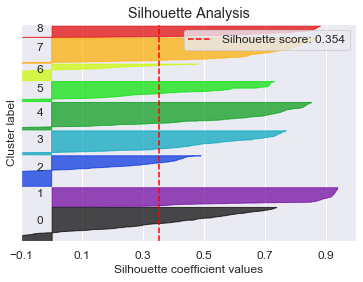

<Figure size 432x288 with 0 Axes>

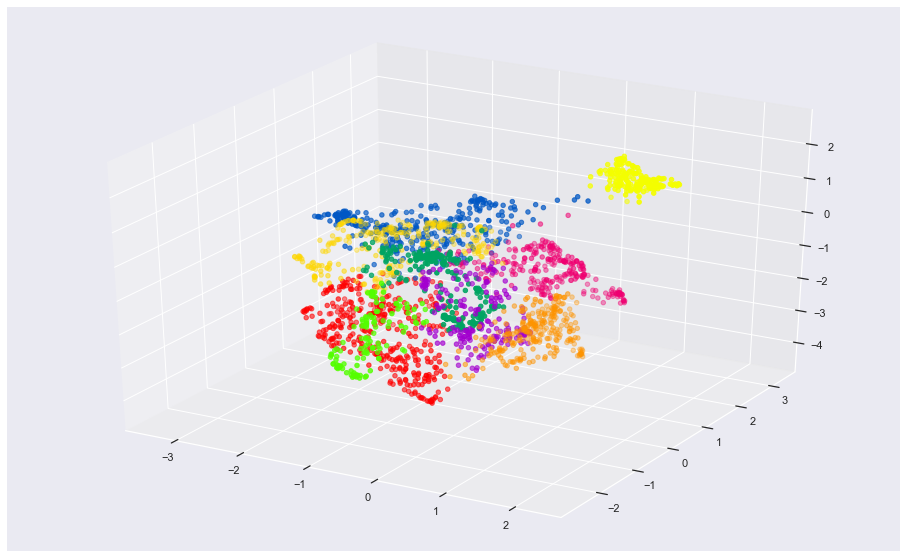

<Figure size 432x288 with 0 Axes>

In [37]:
acc = accuracy_scorer_gensim(w2v_gscv.best_estimator_)
# Get the embeddings
vectors = w2v_gscv.best_estimator_.named_steps['w2v'].gensim_model.wv.vectors
# Reduce dimensionality for clustering and plotting
print('Reducing dimensionality of final word2vec embeddings for clustering...')
umapper = umap.UMAP(n_components=3)
umap_vectors = umapper.fit_transform(vectors)
# Cluster
print('Performing clustering...')
clusters = clust_gscv.best_estimator_.fit_predict(umap_vectors)

# Plot the silhouette graph
print('Plotting silhouette graph...')
skplt.metrics.plot_silhouette(umap_vectors, clusters, metric='cosine')
# Output the plot
if in_ipynb:
	plt.show()
else:
	plt.savefig(os.path.join(SAVE_PATH, 'silhouette_plot.png'))
# Clear
plt.gcf().clear()

# Plot the 3d clustered embeddings
# Make a list of 3d coordinates and and associated cluster for each drug
print('Plotting clustered 3d-UMAP projected embeddings...')
graph_data = []
index2entity = w2v_gscv.best_estimator_.named_steps['w2v'].gensim_model.wv.index2entity
for umapcoords, cluster, entity in zip(umap_vectors, clusters, index2entity):
	graph_data.append([umapcoords[0], umapcoords[1], umapcoords[2], cluster, entity])
# Convert to dataframe
graph_data_df = pd.DataFrame(data=graph_data, columns=['x', 'y', 'z', 'cluster', 'entity'])
# Save the dataframe (to eventually manually label clusters)
graph_data_df.sort_values(by='cluster', inplace=True)
graph_data_df.to_csv(os.path.join(SAVE_PATH, 'graph_dataframe.csv'))
# Plot
ax = plt.figure(figsize=(16,10)).gca(projection='3d')
ax.scatter(
	xs=graph_data_df['x'] ,
	ys=graph_data_df['y'] ,
	zs=graph_data_df['z'] ,
	c=graph_data_df['cluster'],
	cmap='prism'
)
# Output the plot
if in_ipynb:
	plt.show()
else:
	plt.savefig(os.path.join(SAVE_PATH, 'clusted_embeddings_plot.png'))
# Clear
plt.gcf().clear()


In [38]:
print('Best hyperparameters for word2vec embeddings: {}'.format(w2v_gscv.best_params_))


Best hyperparameters for word2vec embeddings: {'w2v__alpha': 0.033, 'w2v__hs': 0, 'w2v__iter': 32, 'w2v__min_count': 5, 'w2v__sg': 1, 'w2v__size': 64, 'w2v__workers': 1}
